<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.io import imread
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import skimage.io
from skimage.transform import resize

%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class LFWDataset(Dataset):
    def __init__(self, data_list, transform):
        self.data = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.transform(self.data[index])
        return image

def transform():
    transform = transforms.Compose([
            transforms.ToTensor()
        ])
    return transform

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

In [ ]:
trainset = LFWDataset(train_photos, transform=transform())
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
validset = LFWDataset(val_photos, transform=transform())
val_loader = DataLoader(validset, batch_size=32)

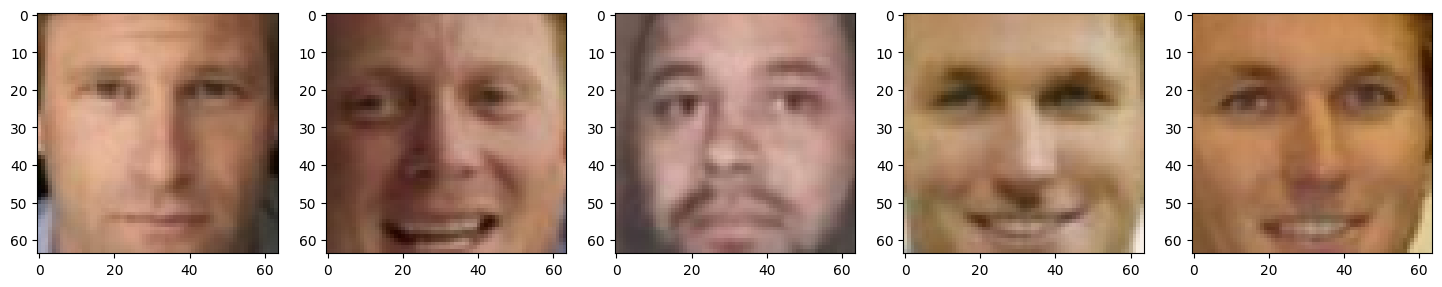

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 5))
for i in range(5):
    axs[i].imshow(train_photos[i])

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            nn.Linear(dim_code * dim_code, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, dim_code),
            nn.ReLU(),
            nn.BatchNorm1d(dim_code),
            nn.Dropout(0.2),
            nn.Linear(dim_code, 36)
        )

        self.dropout = nn.Dropout(0.2)
        self.decoder = torch.nn.Sequential(
            nn.Linear(36, dim_code),
            nn.ReLU(),
            nn.BatchNorm1d(dim_code),
            nn.Dropout(0.2),
            nn.Linear(dim_code, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, dim_code * dim_code),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = x.reshape(-1, dim_code * dim_code)
        latent_code = self.encoder(x)
        reconstruction = self.dropout(self.decoder(latent_code))
        reconstruction = reconstruction.view(-1, 3, dim_code, dim_code)

        return reconstruction, latent_code

    def sampler(self, z):
        generated = self.decoder(z)
        generated = generated.view(-1, 3, dim_code, dim_code)
        return generated

In [ ]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

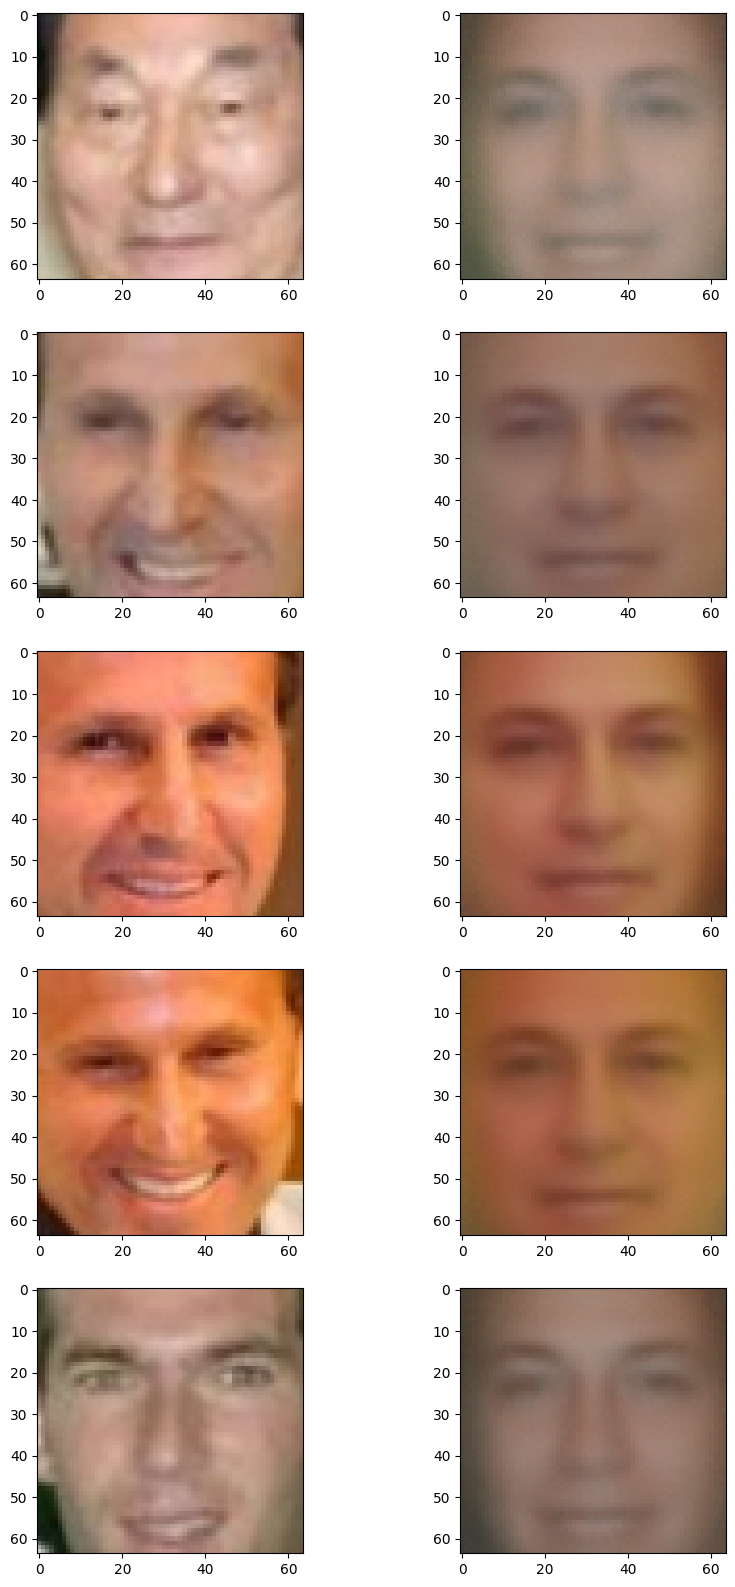

epoch: 99, 
train loss: 0.06651229074313528 
loss: 0.020635127432241634


In [ ]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

n_epochs = 100
train_losses = []
val_losses = []
valid_loss_min = np.Inf

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch = X_batch.float()
        reconstructed, latent_code = autoencoder(X_batch.to(device))
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.float()
            reconstructed, latent_code = autoencoder(X_batch.to(device))

            loss = criterion(reconstructed, X_batch.to(device))
            val_losses_per_epoch.append(loss.item())

    if val_losses_per_epoch[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_losses_per_epoch[-1]))
        torch.save(autoencoder.state_dict(), 'model.pt')
        valid_loss_min = val_losses_per_epoch[-1]

    reconstructed = reconstructed.cpu()
    X_batch = X_batch.cpu()
    clear_output(wait=True)
    plt.figure(figsize=(10, 20))
    for i, (gt, res) in enumerate(zip(X_batch[:5], reconstructed[:5])):
        gt = gt.permute(1,2,0).detach().numpy()
        res = res.permute(1,2,0).detach().numpy()
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res)
    plt.show()

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f'epoch: {epoch}, \ntrain loss: {train_losses[-1]} \nloss: {val_losses[-1]}')



Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

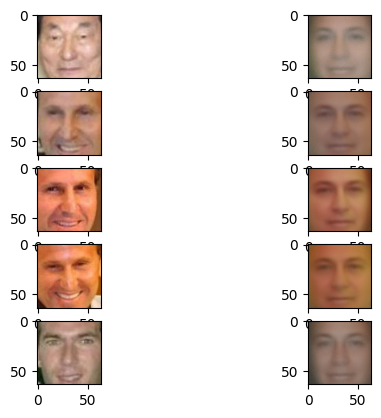

In [ ]:
autoencoder.load_state_dict(torch.load('model.pt'))

for i, (gt, res) in enumerate(zip(X_batch[:5], reconstructed[:5])):
    gt = gt.permute(1,2,0).detach().numpy()
    res = res.permute(1,2,0).detach().numpy()
    plt.subplot(5, 2, 1 + 2*i)
    plt.imshow(gt)
    plt.subplot(5, 2, 2 + 2*i)
    plt.imshow(res)
plt.show()


Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

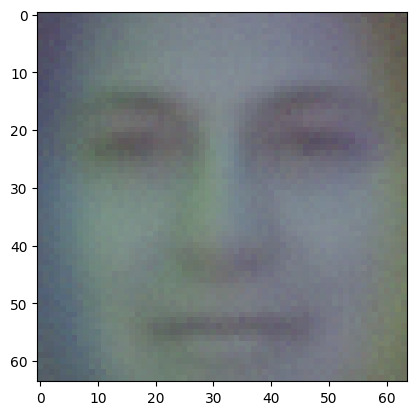

In [ ]:
rand_img = np.random.normal(0, 1, size=(3, 36))
output = autoencoder.sampler(torch.FloatTensor(rand_img).to(device))
plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smile_indexes = train_attrs[train_attrs['Smiling'] > 1.5][['Smiling']].index
sad_indexes = train_attrs[train_attrs['Smiling'] < -1.5][['Smiling']].index

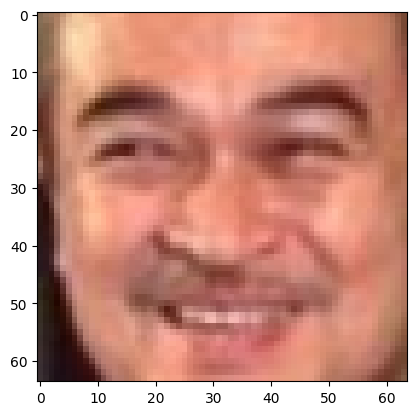

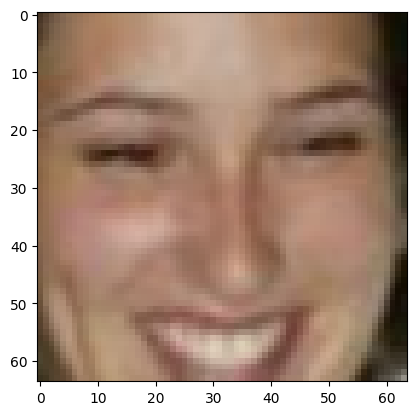

In [ ]:
for i in smile_indexes[:2]:
    plt.imshow(train_photos[i])
    plt.show()

In [ ]:
autoencoder.eval()
latent_smile_space = []
with torch.no_grad():
    for idx in smile_indexes:
        image = torch.FloatTensor(train_photos[idx]).permute(2, 0, 1)
        reconstructed, latent_code = autoencoder(image.to(device))
        latent_smile_space.append(latent_code)

final = None
for i in latent_smile_space:
    if final is None:
        final = i
    else:
        final += torch.tensor(i)

smile_vector = final/len(latent_smile_space)

<ipython-input-50-46dc0c65e554>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final += torch.tensor(i)


In [ ]:
autoencoder.eval()
latent_not_smile_space = []
with torch.no_grad():
    for idx in sad_indexes:
        image = torch.FloatTensor(train_photos[idx]).permute(2, 0, 1)
        reconstructed, latent_code = autoencoder(image.to(device))
        latent_not_smile_space.append(latent_code)

final = None
for i in latent_smile_space:
    if final is None:
        final = i
    else:
        final += torch.tensor(i)

not_smile_vector = final/len(latent_not_smile_space)

<ipython-input-51-e263b1a85bbc>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final += torch.tensor(i)


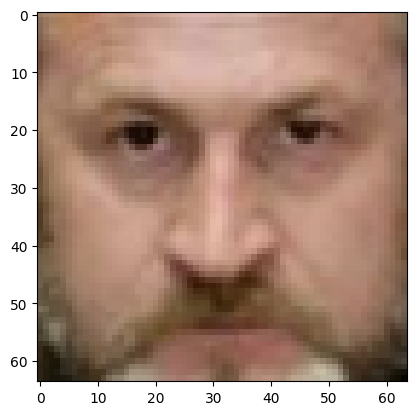

In [ ]:
sad_face = torch.FloatTensor(train_photos[sad_indexes[15]]).permute(2, 0, 1)
plt.imshow(train_photos[sad_indexes[15]])


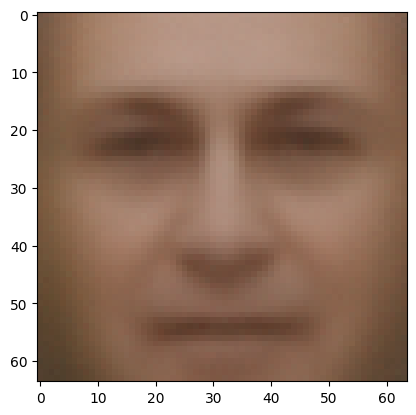

In [ ]:
reconstructed, latent_code = autoencoder(torch.FloatTensor(sad_face).to(device))
latent_code = latent_code + (smile_vector.to(device)*0.2)
output = autoencoder.sampler(latent_code)
plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:02<00:00, 4886650.60it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 129886.54it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:51<00:00, 32179.66it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 2768569.80it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
vae_latent_dim = 64

In [ ]:
class VAE(nn.Module):
    def __init__(self):

        super().__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 20)
        self.fc22 = nn.Linear(512, 20)
        self.relu = nn.ReLU()

        self.fc3 = nn.Linear(20, 512)
        self.fc4 = nn.Linear(512, 784)

    def encode(self, x):

        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        mu = self.fc21(x)
        logsigma = self.fc22(x)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):

        z = self.relu(self.fc3(z))
        reconstruction = torch.sigmoid(self.fc4(z))

        return reconstruction

    def forward(self, x):

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return reconstruction, mu, logsigma


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    loss = 1 / 2 * (1 + logsigma - mu.pow(2) - logsigma.exp()).sum()
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction="sum")
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return -KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

vae = VAE().to(device)

optimizer = optim.AdamW(vae.parameters(), lr=1e-4)

In [ ]:
def vae_train(model, criterion, optimizer, train_dataset, val_dataset, epochs, batch_size):
    train_losses = []
    val_losses = []

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(epochs), leave=False, desc="epoch"):

        train_losses_per_epoch = []
        val_losses_per_epoch = []

        model.train()
        for batch in tqdm(train_loader, leave=False, desc="train batch"):
            batch = batch[0].to(device)
            optimizer.zero_grad()

            reconstruction, mu, log_var = model(batch)
            reconstruction = reconstruction.view(-1, 28, 28)[:, None, :, :]

            loss = criterion(batch.float(), mu, log_var, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader, leave=False, desc="val batch"):
                batch = batch[0].to(device)

                reconstruction, mu, log_var = model(batch)
                reconstruction = reconstruction.view(-1, 28, 28)[:, None, :, :]

                loss = criterion(batch.float(), mu, log_var, reconstruction)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [ ]:
vae_train_loss, vae_val_loss = vae_train(vae, criterion, optimizer, train_dataset, test_dataset, 20, batch_size)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

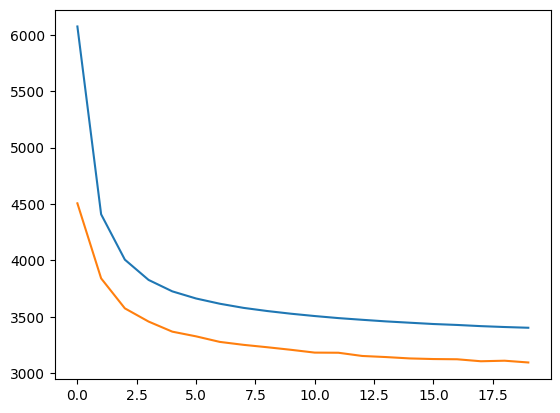

In [ ]:
plt.plot(vae_train_loss, label="train")
plt.plot(vae_val_loss, label="val")

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def visualize_vae(model, train_dataset, n_images=5):
    model.eval()
    with torch.no_grad():
        for i in range(n_images):
            image = torch.FloatTensor(train_dataset[i][0]).unsqueeze(0).to(device)
            decoded_image = model(image)[0].view(-1, 28, 28)[0].cpu().detach()
            fig, axs = plt.subplots(1, 2, figsize=(18, 5))
            axs[0].imshow(train_dataset[i][0][0])
            axs[1].imshow(decoded_image)

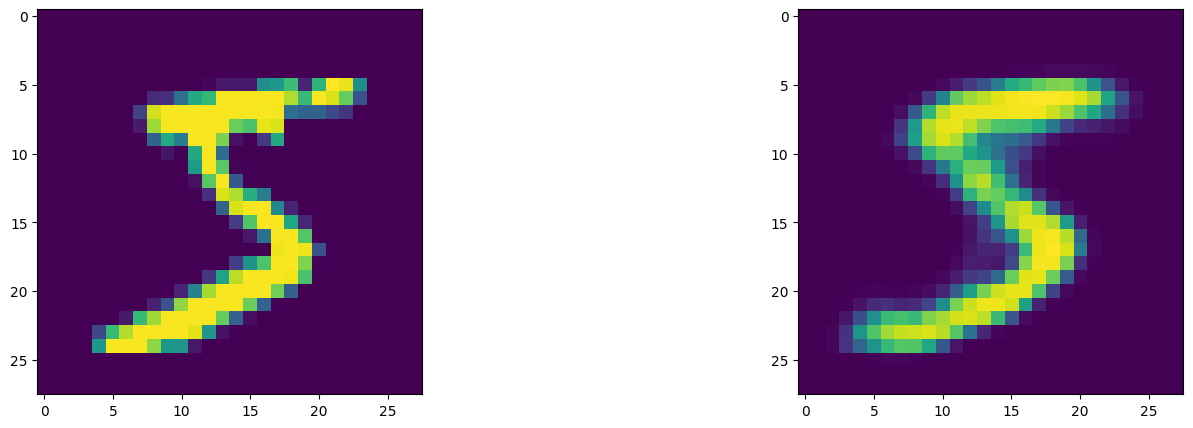

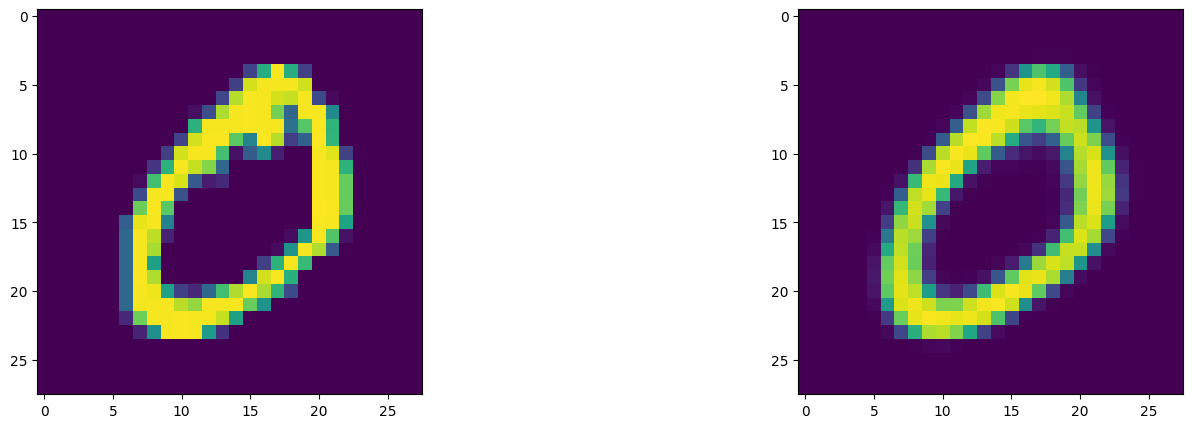

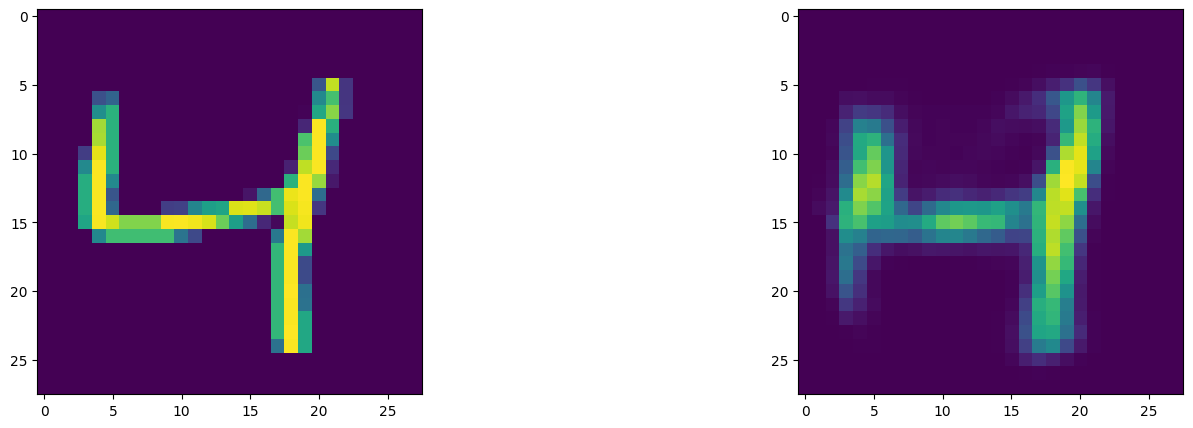

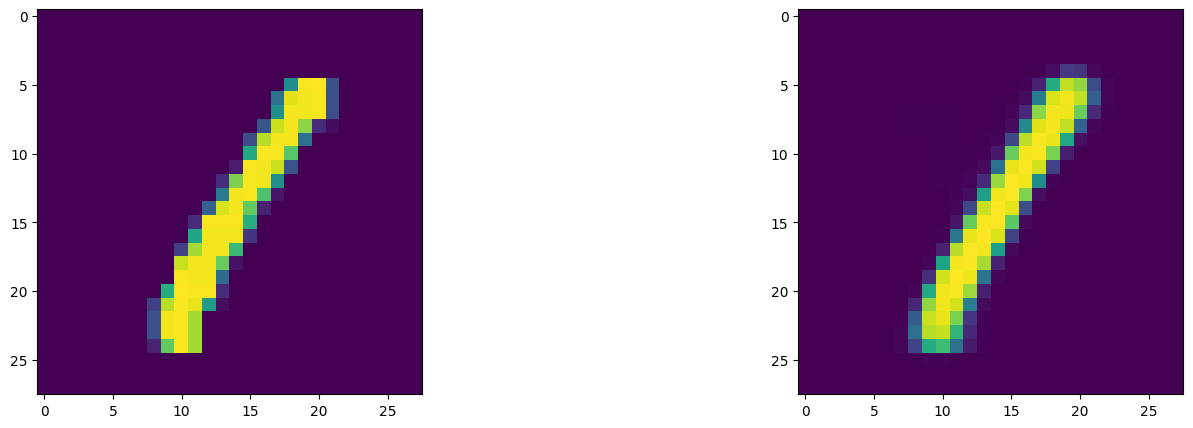

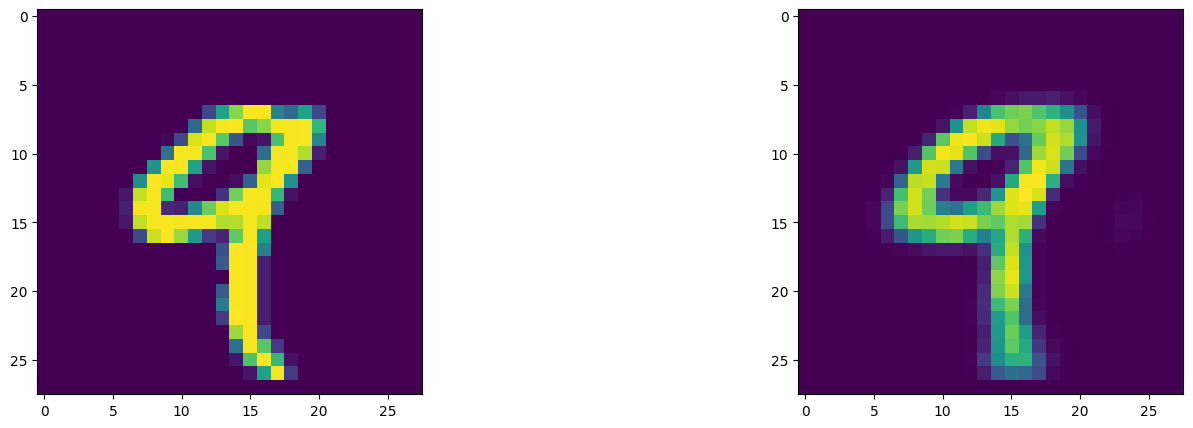

In [ ]:
visualize_vae(vae, train_dataset)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

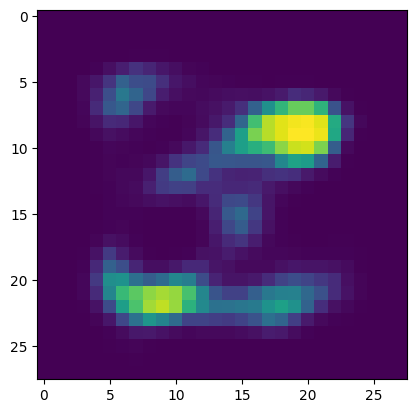

In [ ]:
rand_img = np.random.normal(0, 1, size=(1, 20))
output = vae.decode(torch.FloatTensor(rand_img).to(device))
output = output.view(28, 28, 1).cpu().detach().numpy()
plt.imshow(output)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
latent_codes = []
labels = []
vae.eval()
with torch.no_grad():
    for (image, label) in tqdm(train_dataset):
        input = torch.FloatTensor(image).to(device)
        mu, log_var = vae.encode(input)
        latent_codes.append(mu)
        labels.append(label)
latent_codes = torch.stack(latent_codes).cpu().detach().numpy()[:, 0, :]

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
idxs = np.random.permutation(len(latent_codes))[:10000]
latent_codes_sample = latent_codes[idxs]
labels = np.array(labels)[idxs]
latent_repr = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(latent_codes_sample)

  0%|          | 0/10000 [00:00<?, ?it/s]

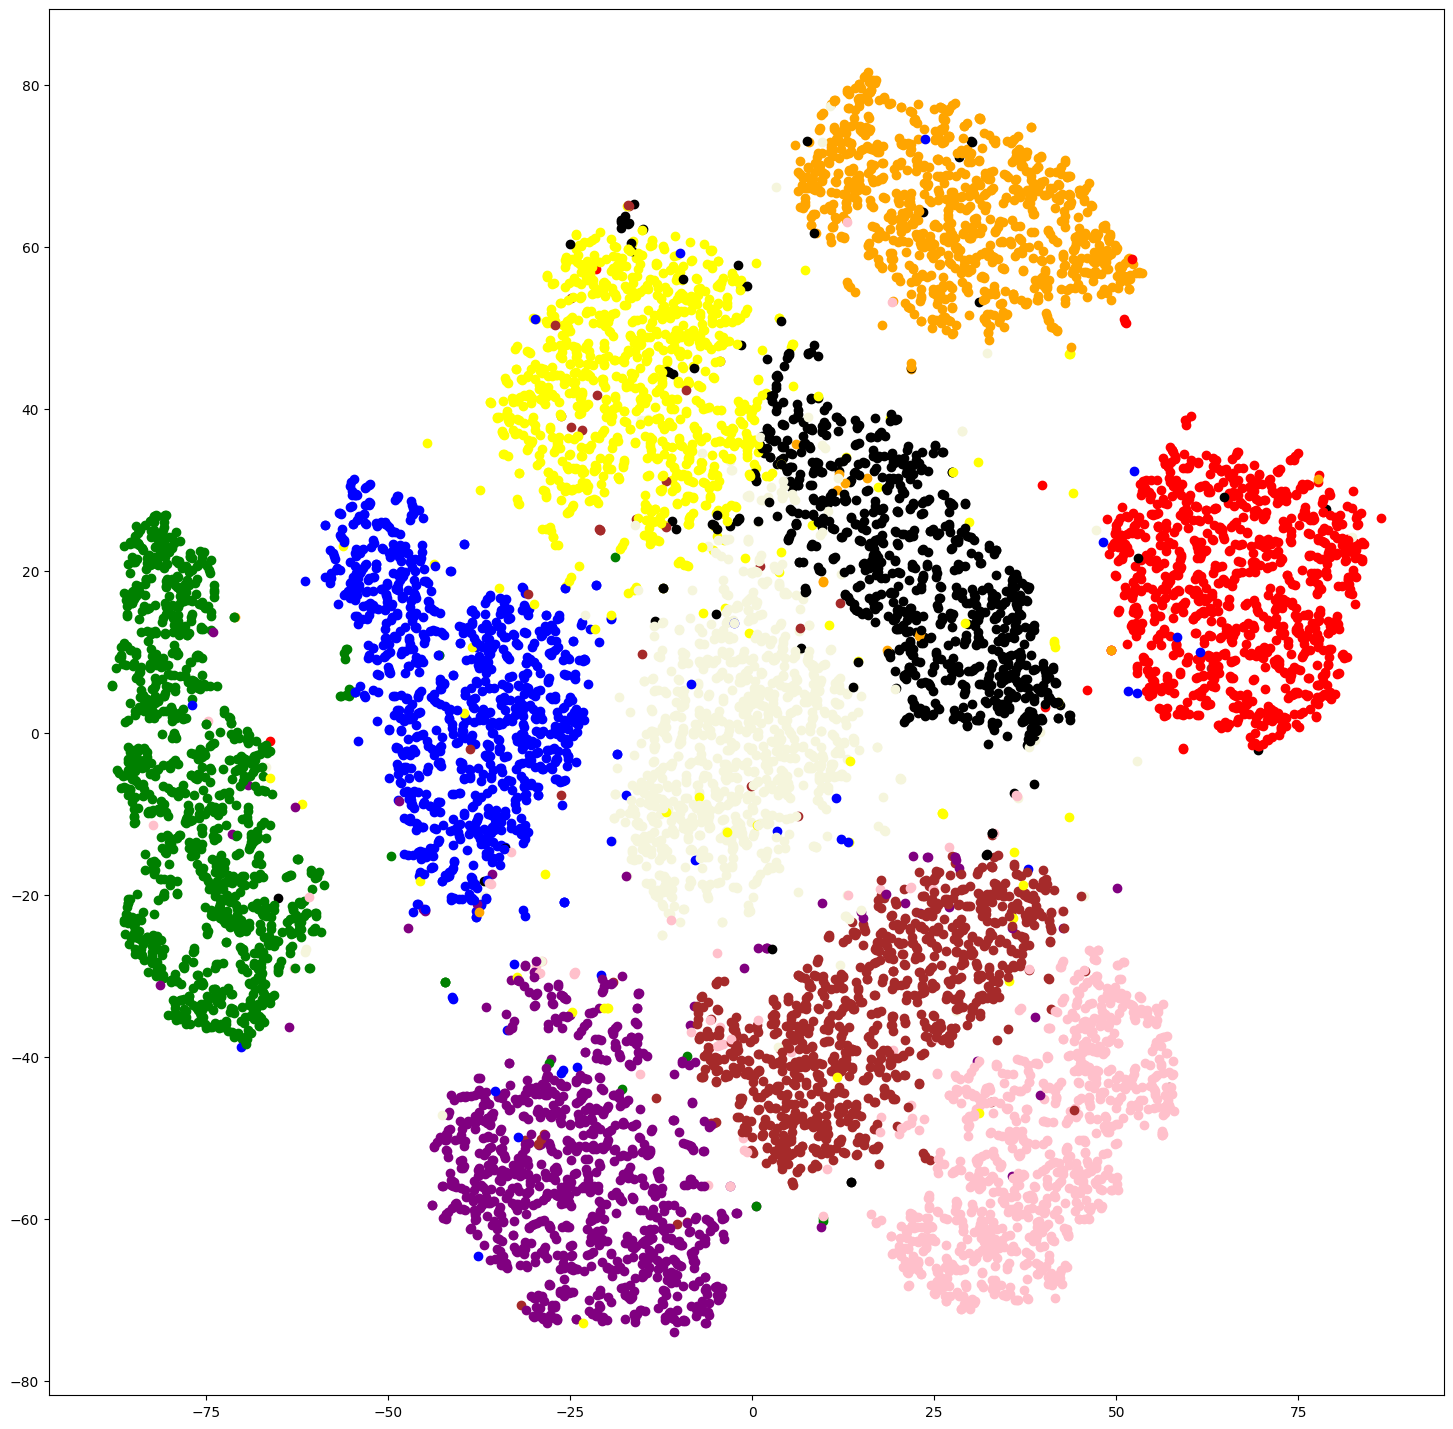

In [ ]:
plt.figure(figsize=(18, 18))
colors = np.array(["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "beige", "brown"])
for i in tqdm(range(len(latent_codes_sample))):
    plt.scatter(latent_repr[i, 0], latent_repr[i, 1], c=colors[labels[i]])
plt.show()

Что вы думаете о виде латентного представления?

В целом, латентные представления классов четко разделены и сгруппированы, однако наблюдаются незначительные разбросы, которые можно объяснить тем, что некоторые цифры по написанию могут быть похожи на другие. Собственно это то, чего мы и добивались устремляя среднее к 0, а дисперсию к 1.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
cvae_latent_dim = 64

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
       super().__init__()

       self.flatten = nn.Flatten()
       self.one_hot_encoder = OneHotEncoder()
       self.one_hot_encoder.fit(np.arange(10)[:, None])

       self.encoder = nn.Sequential(
            nn.Linear(in_features=784 + 10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=cvae_latent_dim * 2),
        )

       self.decoder = nn.Sequential(
            nn.Linear(in_features=cvae_latent_dim + 10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784),
        )

    def encode(self, x, class_num):
       class_encoded = torch.FloatTensor(
            self.one_hot_encoder.transform(class_num.cpu().detach().numpy()[:, None]).toarray()
        ).to(device)
       x = self.flatten(x)
       x = torch.cat((x, class_encoded), dim=1)
       x = self.encoder(x).view(-1, 2, cvae_latent_dim)
       mu = x[:, 0, :]
       logsigma = x[:, 1, :]
       return mu, logsigma, class_encoded

    def gaussian_sampler(self, mu, logsigma):
       if self.training:
           std = torch.exp(0.5 * logsigma)
           eps = torch.randn_like(std)
           sample = mu + eps * std
           return sample
       else:
           return mu

    def decode(self, z, class_encoded):
       z = torch.cat((z, class_encoded), dim=1)
       x = self.decoder(z)
       reconstruction = torch.sigmoid(x)
       return reconstruction

    def forward(self, x):
       mu, logsigma, class_encoded = self.encode(*x)
       z = self.gaussian_sampler(mu, logsigma)
       reconstruction = self.decode(z, class_encoded)
       return reconstruction, mu, logsigma

In [ ]:
def cvae_train(model, criterion, optimizer, train_dataset, val_dataset, epochs, batch_size):
    train_losses = []
    val_losses = []

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(epochs), leave=False, desc="epoch"):

        train_losses_per_epoch = []
        val_losses_per_epoch = []

        model.train()
        for X_batch, y_batch in tqdm(train_loader, leave=False, desc="train batch"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            reconstruction, mu, logsigma = model((X_batch, y_batch))
            reconstruction = reconstruction.view(-1, 28, 28)[:, None, :, :]

            loss = criterion(X_batch, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, leave=False, desc="val batch"):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                reconstruction, mu, logsigma = model((X_batch, y_batch))
                reconstruction = reconstruction.view(-1, 28, 28)[:, None, :, :]

                loss = criterion(X_batch, mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [ ]:
cvae = CVAE().to(device)
loss_func = loss_vae
optim_func = optim.AdamW(cvae.parameters(), lr=1e-4)

In [ ]:
cvae_train_loss, cvae_val_loss = cvae_train(cvae, loss_func, optim_func, train_dataset, test_dataset, 40, 32)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

train batch:   0%|          | 0/1875 [00:00<?, ?it/s]

val batch:   0%|          | 0/313 [00:00<?, ?it/s]

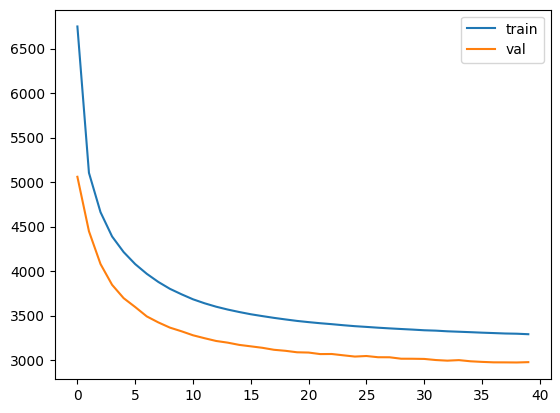

In [ ]:
plt.plot(cvae_train_loss, label="train")
plt.plot(cvae_val_loss, label="val")
plt.legend()
plt.show()

In [ ]:
def visualize_cvae(model, dataset, n_images=5):
    model.eval()
    with torch.no_grad():
        loader = DataLoader(dataset, batch_size=n_images)
        X_batch, y_batch = next(iter(loader))
        reconstruction, mu, log_var = model((X_batch.to(device), y_batch.to(device)))
        reconstruction = reconstruction.view(-1, 28, 28)[:, None, :, :]

    for i in range(n_images):
        fig, axs = plt.subplots(1, 2, figsize=(18, 5))
        axs[0].imshow(X_batch[i][0])
        axs[1].imshow(reconstruction[i][0].cpu().detach().numpy())

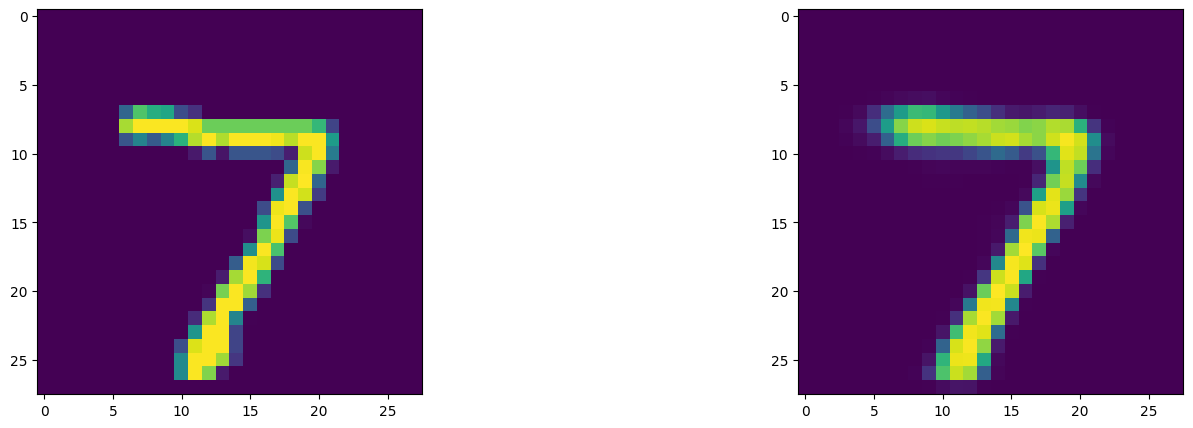

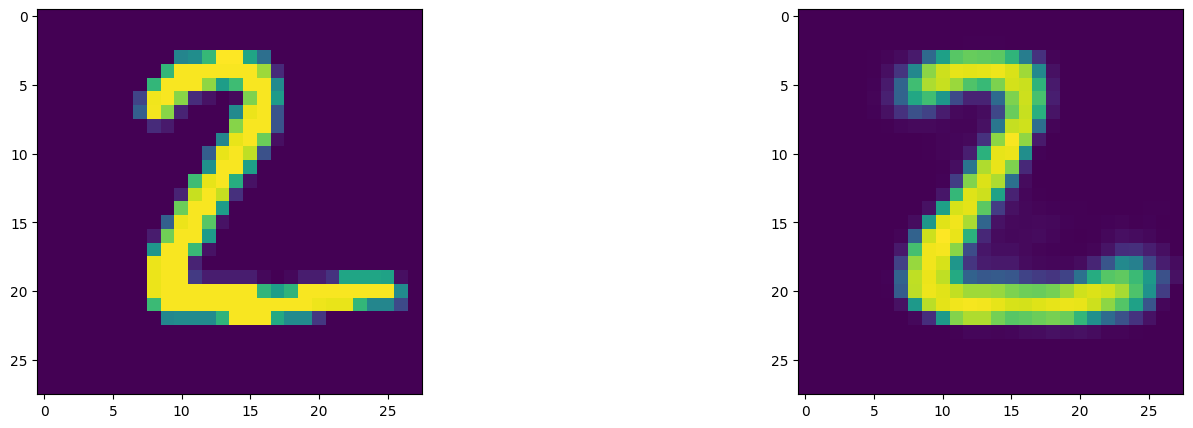

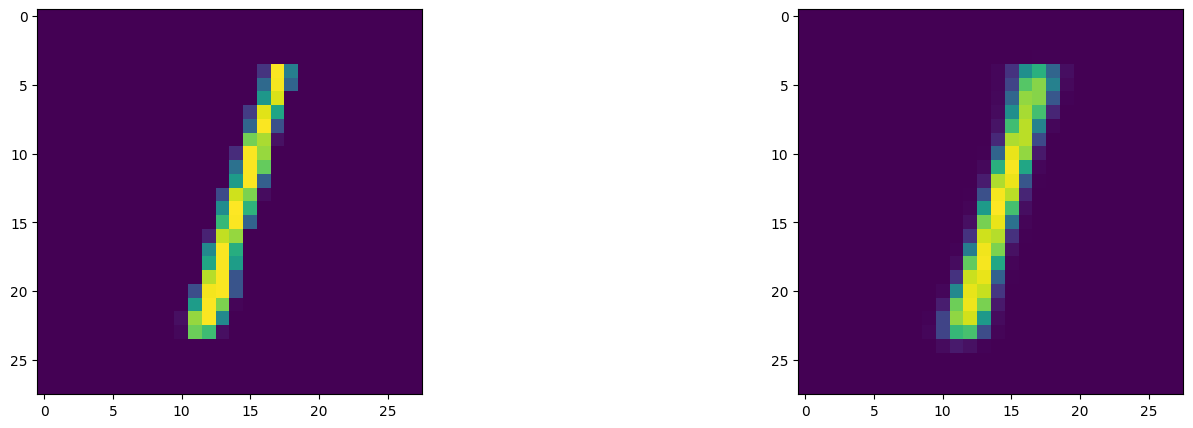

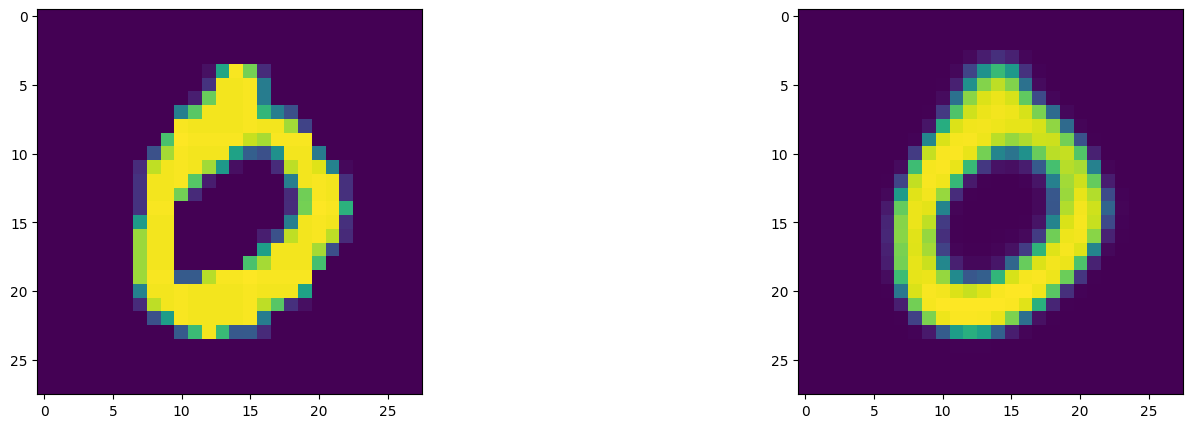

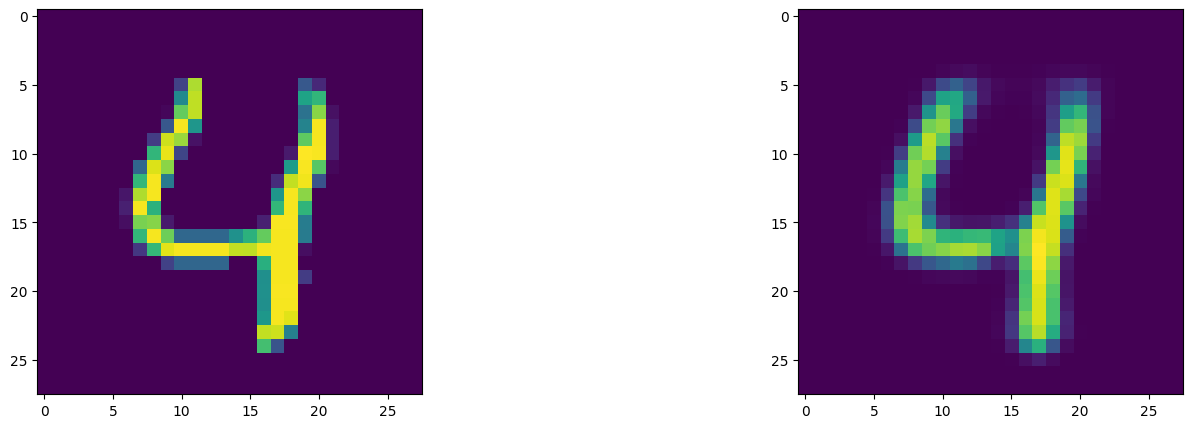

In [ ]:
visualize_cvae(cvae, test_dataset)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
def cvae_create_new_images(model, class_num, n_images):
    model.eval()
    one_hot_encoder = OneHotEncoder()
    one_hot_encoder.fit(np.arange(10)[:, None])
    with torch.no_grad():
        test_loader = DataLoader(test_dataset, batch_size=32)
        X_batch, y_batch = next(iter(test_loader))
        _, mu, _ = model((X_batch.to(device), y_batch.to(device)))

        class_encoded = torch.FloatTensor(one_hot_encoder.transform([[class_num]]).toarray()).to(device)
        class_encoded = torch.stack([class_encoded for i in range(n_images)])[:, 0, :]
        z = torch.FloatTensor(np.random.randn(n_images, cvae_latent_dim)).to(device)
        # z = mu.mean(0) + z * mu.std(0)
        output = model.decode(z, class_encoded).view(-1, 28, 28)

    fig, axs = plt.subplots(n_images // 5, 5, figsize=(18, 5))
    for i in range(n_images):
        axs[i % 5].imshow(output[i].cpu().detach().numpy())

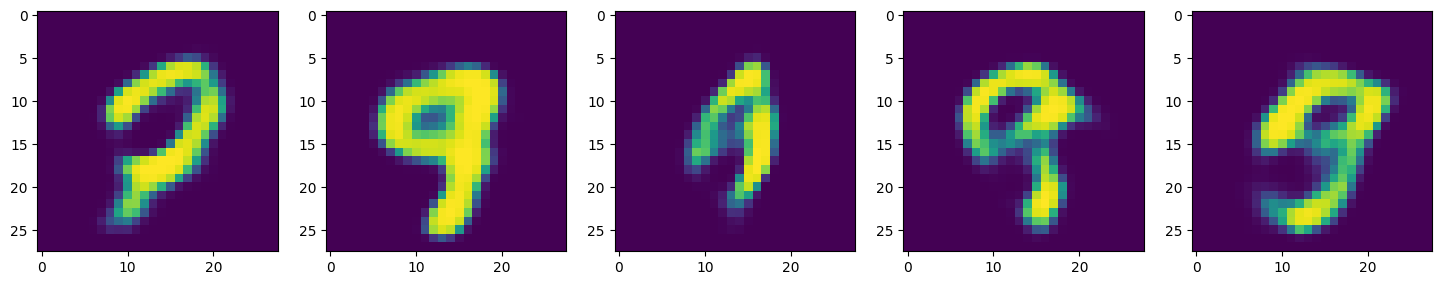

In [ ]:
cvae_create_new_images(cvae, 9, 5)

In [ ]:
def image_from_latent(model, latent_code, class_num):
    model.eval()
    one_hot_encoder = OneHotEncoder()
    one_hot_encoder.fit(np.arange(10)[:, None])

    with torch.no_grad():
        test_loader = DataLoader(test_dataset, batch_size=32)
        X_batch, y_batch = next(iter(test_loader))
        _, mu, _ = model((X_batch.to(device), y_batch.to(device)))

        class_encoded = torch.FloatTensor(one_hot_encoder.transform([[class_num]]).toarray()).to(device)

        latent_code = mu.mean(0) + latent_code * mu.std(0)
        output = model.decode(latent_code, class_encoded).view(-1, 28, 28)
        plt.imshow(output[0].cpu().detach().numpy())

In [ ]:
latent_code = torch.FloatTensor(np.random.randn(1, cvae_latent_dim)).to(device)

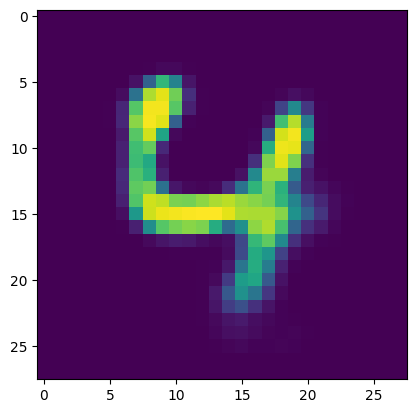

In [ ]:
image_from_latent(cvae, latent_code, 4)

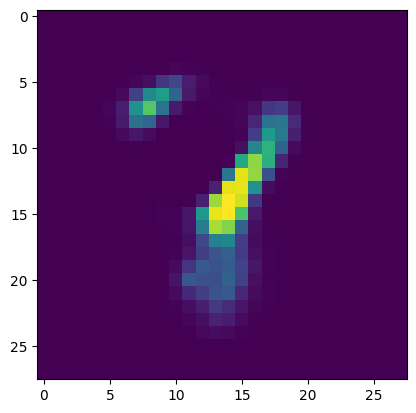

In [ ]:
image_from_latent(cvae, latent_code, 1)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
latent_codes = []
labels = []
cvae.eval()
with torch.no_grad():
    for (image, label) in tqdm(train_dataset):
        input = torch.FloatTensor(image).to(device)
        mu, log_var, class_encoded = cvae.encode(input, torch.tensor([label]).to(device))
        latent_codes.append(mu)
        labels.append(label)
latent_codes = torch.stack(latent_codes).cpu().detach().numpy()[:, 0, :]

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
idxs = np.random.permutation(len(latent_codes))[:10000]
latent_codes_sample = latent_codes[idxs]
labels = np.array(labels)[idxs]

In [ ]:
latent_repr = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(latent_codes_sample)

  0%|          | 0/10000 [00:00<?, ?it/s]

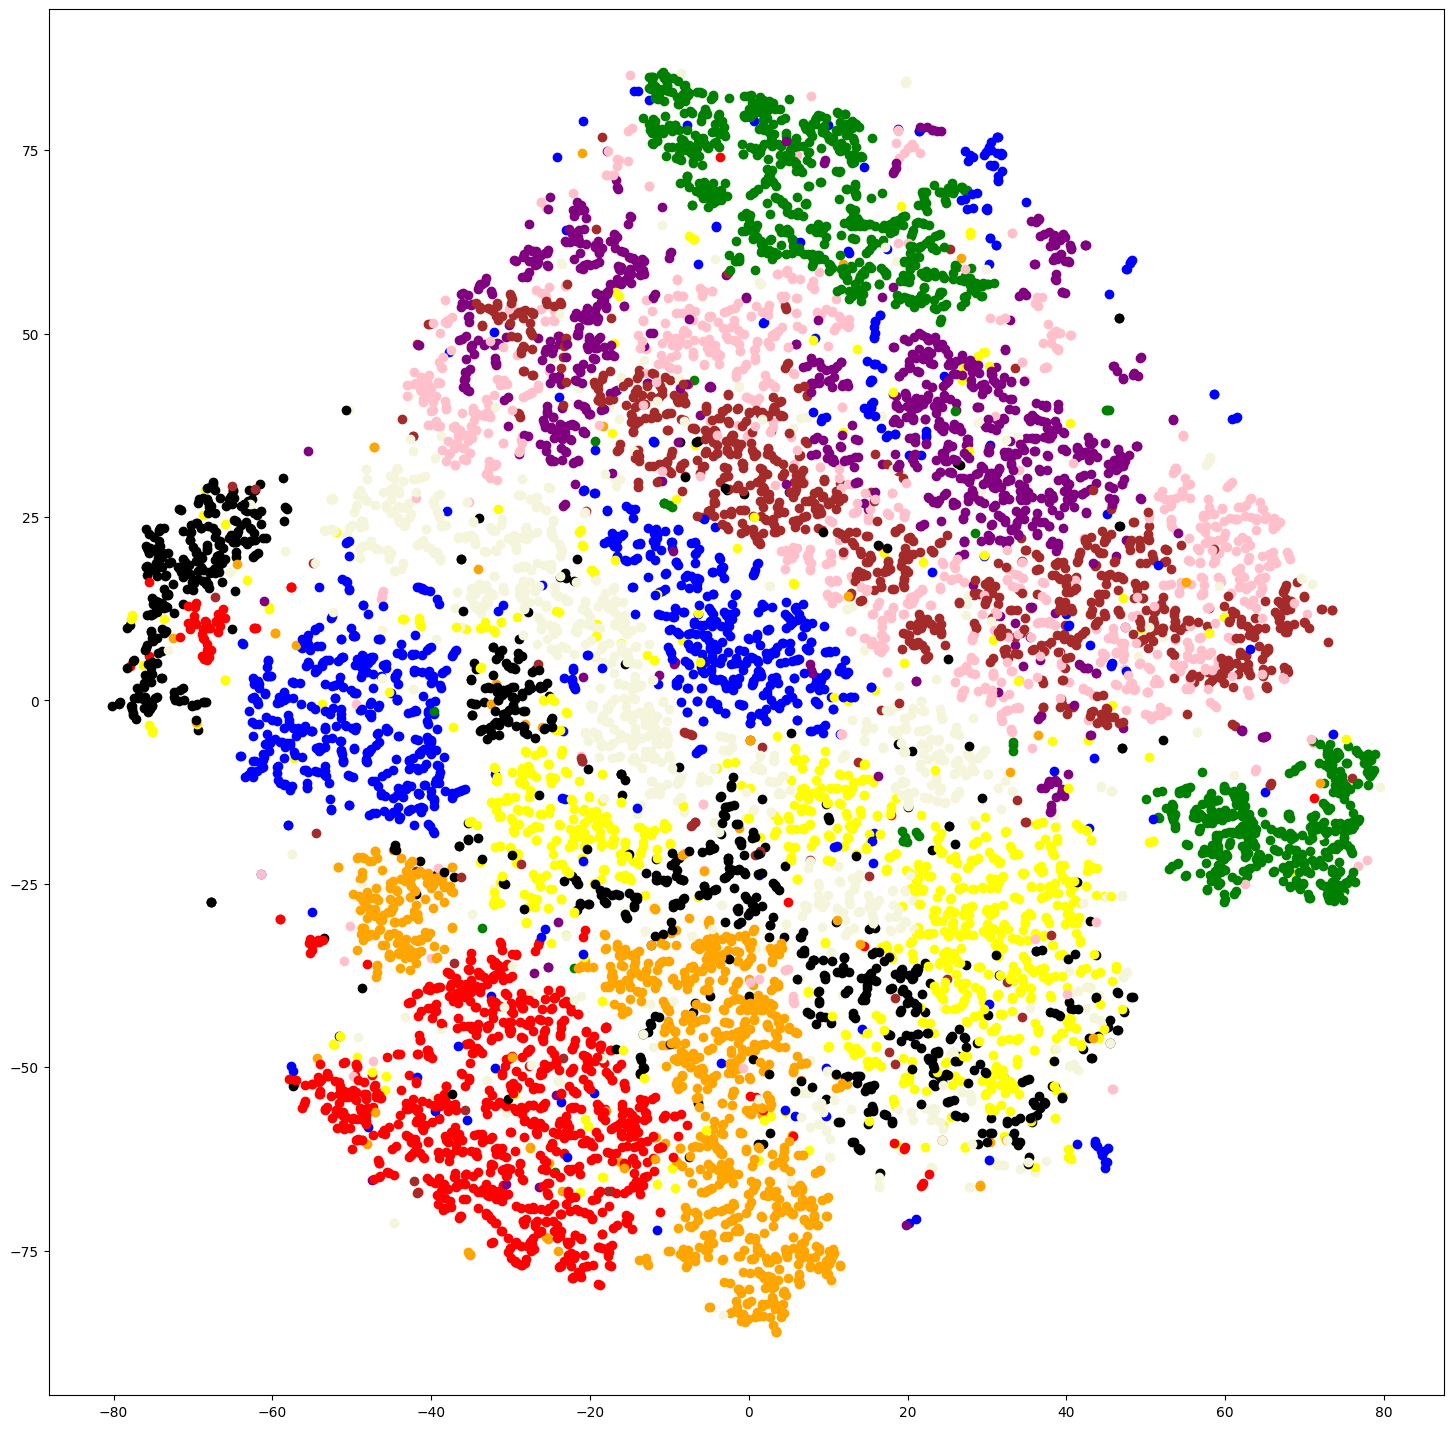

In [ ]:
plt.figure(figsize=(18, 18))
colors = np.array(["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "beige", "brown"])
for i in tqdm(range(len(latent_codes_sample))):
    plt.scatter(latent_repr[i, 0], latent_repr[i, 1], c=colors[labels[i]])
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Отличается: стало больше разбросов между классами цифр